# DATA PREPROCESSING - CLUSTERING

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
from dtw import *
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestCentroid
from tqdm import tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### POSTGRES CONNECTION

In [2]:
conn = pg.connect("dbname=postgres user=postgres password=saude123")

### IMPORT DATA

In [3]:
## Doses
sql_query_doses = pd.read_sql_query ('''
select date, state, sum(doses) as doses from view_vacc vv 
where (vaccine_doses = 'D1' or vaccine_doses = 'D_unica') and state!= 'XX' and state != '' and age_range not in ('0-4','5-9','15-19')
group by date, state
order by date,state
''', conn)

## Population
sql_query_pop = pd.read_sql_query ('''
select state,sum(population) as pop from population_city_2020 pm 
group by state
''', conn)

### JOIN DATA

In [5]:
## Join data and create column doses per population ['doses_prop']

df = sql_query_doses.merge(sql_query_pop,on='state')
df['doses_prop'] = df['doses'] / df['pop']
df = df.drop(['pop'],axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['state','date'])

### PROPORTIONAL VACCINATION TIME SERIES

In [6]:
## It creates a daily proportional vaccination time series for each state

df_time_series = pd.DataFrame(columns = df['state'].unique(), index = df['date'].unique()).sort_index()
for state in df_time_series.columns:
    df_time_series[state] = df[df['state']==state].set_index('date')['doses_prop']
df_time_series = df_time_series.fillna(0)
df_time_series

,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
2021-01-15,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.088482e-07,0.000000e+00,2.460598e-07,0.000000,0.000001,...,1.736587e-07,0.000000,2.829523e-07,0.000000,0.000000,0.000000,2.757669e-07,0.000000,0.000000e+00,0.000000
2021-01-16,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.176965e-07,0.000000e+00,2.460598e-07,0.000000,0.000000,...,0.000000e+00,0.000000,8.488568e-07,0.000000,0.000000,0.000000,2.757669e-07,0.000000,2.160325e-08,0.000000
2021-01-17,0.000001,2.983700e-07,0.000004,0.000000,0.000005,1.850420e-06,9.819488e-07,4.921197e-07,0.000002,0.000002,...,4.341469e-07,0.000002,8.488568e-07,0.000002,0.000006,0.000003,1.930368e-06,0.000003,5.184780e-06,0.000002
2021-01-18,0.000002,3.580440e-06,0.000005,0.000002,0.000007,1.317064e-05,1.963898e-06,1.550177e-05,0.000018,0.000002,...,2.865369e-06,0.000009,2.263618e-06,0.000002,0.000016,0.000019,2.895552e-06,0.000003,2.300746e-05,0.000008
2021-01-19,0.000064,1.512736e-04,0.000413,0.000296,0.000524,4.802384e-04,7.214051e-04,1.582165e-04,0.000317,0.000121,...,1.848597e-04,0.000204,5.715636e-05,0.000154,0.000030,0.000165,3.664942e-04,0.000337,1.865441e-04,0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10,0.000243,3.693821e-04,0.000096,0.000078,0.000264,1.577211e-04,2.510516e-04,4.389708e-04,0.000279,0.000224,...,3.956815e-04,0.000317,2.170244e-04,0.000295,0.000513,0.000358,3.510513e-04,0.000173,4.411816e-04,0.000280
2022-01-11,0.000131,3.458109e-04,0.000082,0.000051,0.000256,1.946207e-04,2.402501e-04,5.135269e-04,0.000203,0.000214,...,4.287634e-04,0.000304,2.478662e-04,0.000227,0.000553,0.000358,3.880040e-04,0.000155,4.889031e-04,0.000345
2022-01-12,0.000116,3.135869e-04,0.000065,0.000034,0.000192,8.261581e-05,3.066954e-04,2.106272e-04,0.000209,0.000173,...,3.829175e-04,0.000283,2.436219e-04,0.000250,0.000433,0.000324,3.390554e-04,0.000125,1.084483e-05,0.000216
2022-01-13,0.000072,2.867336e-04,0.000047,0.000037,0.000183,6.911863e-05,2.870564e-04,1.451753e-05,0.000235,0.000173,...,2.855818e-04,0.000249,2.181562e-04,0.000191,0.000472,0.000289,3.889692e-04,0.000134,3.451767e-04,0.000297


### MOVING AVERAGE AND NORMALIZATION

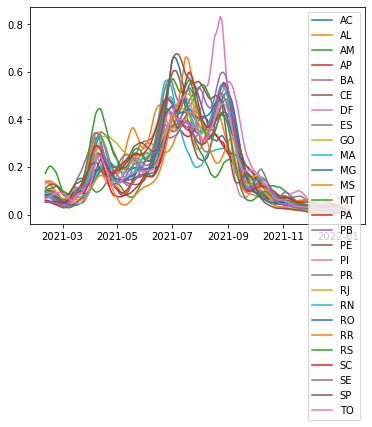

In [7]:
## It creates and normalizes a 14 days moving average

df_time_series_14 = (df_time_series.rolling(14).mean().tail(352) - df_time_series.rolling(14).mean().tail(352).min().min()) / (df_time_series.rolling(14).mean().tail(352).max().max() - df_time_series.rolling(14).mean().tail(352).min().min())

for uf in df_time_series.columns:
    plt.plot(df_time_series_14[uf].rolling(14).mean(),label=uf)
    plt.legend()

### DYNAMIC TIME WARPING (DTW)

In [10]:
## It creates a 27x27 matrix which holds the distance between any two states by using DTW

silhouette_avg_dict = dict.fromkeys(range(1,41))
calinski_dict = dict.fromkeys(range(1,41))
window_sizes = range(1,41)

for window_size in window_sizes:
    df_distances = pd.DataFrame(columns = df['state'].unique(), index = df['state'].unique(), data = 0)
    for uf_1 in df_distances.columns:
        for uf_2 in df_distances.columns:
            X = np.array(df_time_series_14[uf_1])
            Y = np.array(df_time_series_14[uf_2])
            alignment = dtw(X,Y,dist_method='euclidean', window_type = "slantedband", window_args = {'window_size' : window_size}, keep_internals = True)
            df_distances.loc[uf_1,uf_2] = alignment.distance
    
    calinski_list = list()
    silhouette_avg_list = list()
    
    for k in range(3,9):
        clustering = AgglomerativeClustering(n_clusters = k, linkage = 'complete',affinity = 'precomputed').fit(df_distances)
        cluster_labels = clustering.labels_
        calinski_score = calinski_harabasz_score(df_distances, cluster_labels)
        silhouette_avg = silhouette_score(df_distances, cluster_labels)
        calinski_list.append(calinski_score)
        silhouette_avg_list.append(silhouette_avg)
        
    calinski_dict[window_size] = calinski_list
    silhouette_avg_dict[window_size] = silhouette_avg_list


### DEFINE THE WINDOW SIZE BY SILHOUETTE SCORE

In [ ]:
for i in window_sizes:
    print(i,max(silhouette_avg_dict[i]))

### DEFINE THE NUMBER OF CLUSTERS BY SILHOUETTE SCORE

In [ ]:
for window_size in range(0,3):
    plt.plot(range(3,9), silhouette_avg_dict[window_size], label = window_size)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette score")
plt.show()

### CLUSTERING TIME SERIES

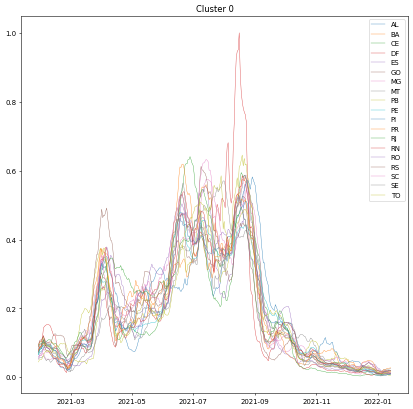

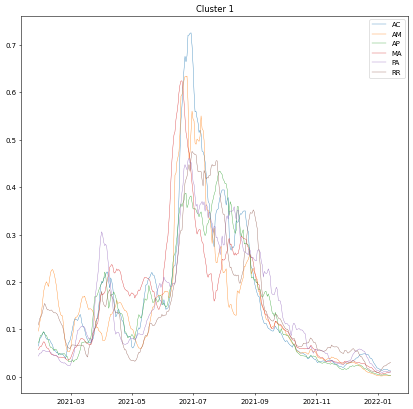

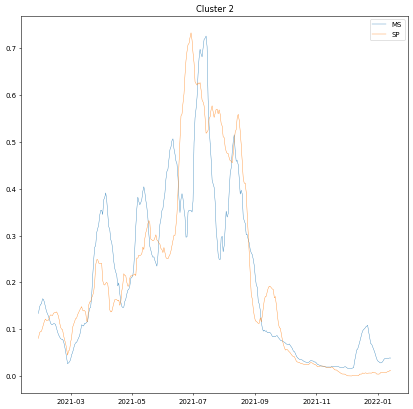

In [11]:
## window_size = 24
## n_clusters = 3

df_distances = pd.DataFrame(columns = df['state'].unique(), index = df['state'].unique(), data = 0)
for uf_1 in df_distances.columns:
    for uf_2 in df_distances.columns:
        X = np.array(df_time_series_14[uf_1])
        Y = np.array(df_time_series_14[uf_2])
        alignment = dtw(X,Y,dist_method='euclidean', window_type = "slantedband", window_args = {'window_size' : 24}, keep_internals = True)
        df_distances.loc[uf_1,uf_2] = alignment.distance
        
clustering = AgglomerativeClustering(n_clusters = 3, linkage = 'complete',affinity = 'precomputed').fit(df_distances)
cluster_labels = clustering.labels_

for cluster in np.unique(cluster_labels):
    
    fig, ax = plt.subplots(figsize=(10,10), dpi=50)
    ax.set_title('Cluster %s'%cluster)
             
    for index, uf in enumerate(df_time_series.columns):
        if cluster_labels[index] == cluster:
            ax.plot(df_time_series_14[uf], label = uf, linewidth = 0.5)
            leg = ax.legend();
    plt.show()Fin

In [12]:
pd.Series(index = df_distances.columns,data = cluster_labels).to_dict()

{'AC': 1,
 'AL': 0,
 'AM': 1,
 'AP': 1,
 'BA': 0,
 'CE': 0,
 'DF': 0,
 'ES': 0,
 'GO': 0,
 'MA': 1,
 'MG': 0,
 'MS': 2,
 'MT': 0,
 'PA': 1,
 'PB': 0,
 'PE': 0,
 'PI': 0,
 'PR': 0,
 'RJ': 0,
 'RN': 0,
 'RO': 0,
 'RR': 1,
 'RS': 0,
 'SC': 0,
 'SE': 0,
 'SP': 2,
 'TO': 0}